## MEMA Inter-subject analysis

This notebook will 
- Process and generate reports for all the dataset following procedure detailed in Bruxism detection
- Display several metrics for all patients of the datasets
- Display group analysis differences between tinnitus overnight increase patients and stable overnight patients (for tinnitus masking volume and VAS scales)
- Display correlation plots between tinnitus evolution overnight and number of bruxisme episodes per hour (for tinnitus masking volume and VAS scales)

In [1]:
import os
PATH = os.getcwd() 
import sys
sys.path.append(PATH + '/../')
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from statannot import add_stat_annotation
from itertools import combinations
from tinnsleep.data import read_etiology_file


print("config loaded")


config loaded


In [2]:
#Setting parameters
results_file = "data/reports_and_datas_MEMA.pk"
info_file = "data/data_info.csv"
etiology_file = "data/etiology.xlsx"

# PART 1 Compute Results
Skip to Part 2 if results files has been computed already

## Processing of the dataset and report generation

In [17]:
# change --overwrite to True if you want to force to recompute the results
%run ../compute_results.py --mema True --overwrite False

config loaded.
Performs Bruxism: <False>
Performs MEMA: <True>
Will overwrite existing results: <False>
parameters set
Files processed: 
1AC26_cohort2.edf skipped for mema(existing results)
1BA07_nuit_hab.edf skipped for mema(no valid channel)
1BA07_nuit_son.edf skipped for mema(no valid channel)
1CB23_cohort2.edf skipped for mema(existing results)
1CC05_nuit_hab.edf skipped for mema(no valid channel)
1CC05_nuit_son.edf skipped for mema(no valid channel)
1DA15_nuit_hab.edf skipped for mema(existing results)
1DA15_nuit_son.edf skipped for mema(no valid channel)
1DL12_nuit_hab.edf skipped for mema(no valid channel)
1DL12_nuit_son.edf skipped for mema(no valid channel)
1DM32_cohort2.edf skipped for mema(existing results)
1GB18_nuit_hab.edf skipped for mema(existing results)
1GB18_nuit_son.edf skipped for mema(no valid channel)
1GF14_cohort2.edf skipped for mema(existing results)
1GF14_nuit_hab.edf skipped for mema(no valid channel)
1GF14_nuit_son.edf skipped for mema(no valid channel)
1HB

# Part 2 Load and Analysis Results
Part 1 is optional if the .pk has been saved

### Loading results

In [4]:
results = pd.read_pickle(results_file).to_dict()
THR_classif = np.array(results[list(results.keys())[0]]["THR_classif"])

data_info = pd.read_csv(info_file, sep=";").query('mema == 1 & included == 1 & session == "1" ')
etiology = read_etiology_file(etiology_file)
data_info = data_info.merge(etiology,on="subject")
#data_info = pd.read_csv(info_file, sep=";").query('mema == 1 & included == 1 & subject == "1SL21" & session != "6" ')

print(f"Valid files for mema {data_info.shape[0]}")
print(data_info[["filename", "subject", "mema", "emg", "condition", "hyperacusis"]])

# keep only results from query
results= {filename:results[filename] for filename in data_info["filename"].values}

Valid files for mema 27
              filename subject  mema  emg    condition  hyperacusis
0   1DA15_nuit_hab.edf   1DA15     1    1  habituation         True
1   1GB18_nuit_hab.edf   1GB18     1    1  habituation        False
2   1RA17_nuit_hab.edf   1RA17     1    0  habituation        False
3     1HB20_nuit_1.edf   1HB20     1    1  habituation        False
4     1SL21_nuit_2.edf   1SL21     1    1  habituation        False
5     1UC22_nuit_1.edf   1UC22     1    1  habituation        False
6     2GA06_nuit_1.edf   2GA06     1    1      control        False
7     2SJ03_nuit_1.edf   2SJ03     1    1      control        False
8     2LS05_nuit_1.edf   2LS05     1    1      control        False
9     2CT04_nuit_1.edf   2CT04     1    1      control        False
10   1ZN04_cohort2.edf   1ZN04     1    1       batch2         True
11   1HS25_cohort2.edf   1HS25     1    1       batch2        False
12   1PA31_cohort2.edf   1PA31     1    1       batch2         True
13   3NS01_cohort2.edf  

In [5]:
# visualization function
def plot_inter_subjects(results, value): 
    for filename in results.keys():
        y_axis=[]
        #print(results[filename]["reports"][0].keys())
        for report in results[filename]["reports"]:
            y_axis.append(report[value])
        plt.plot(THR_classif[:,1], y_axis, label=filename)
    plt.title('MEMA scoring')
    plt.xlabel('Threshold for classification')
    plt.ylabel(value)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

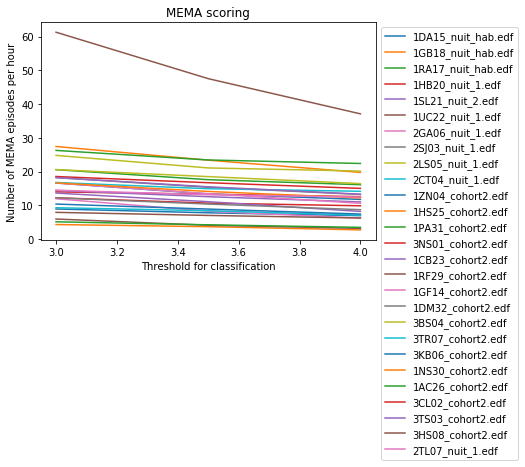

In [6]:
plt.close("all")
plt.figure()
value = "Number of MEMA episodes per hour"
plot_inter_subjects(results, value)

## 2.b Burst Duration 

<Figure size 432x288 with 0 Axes>

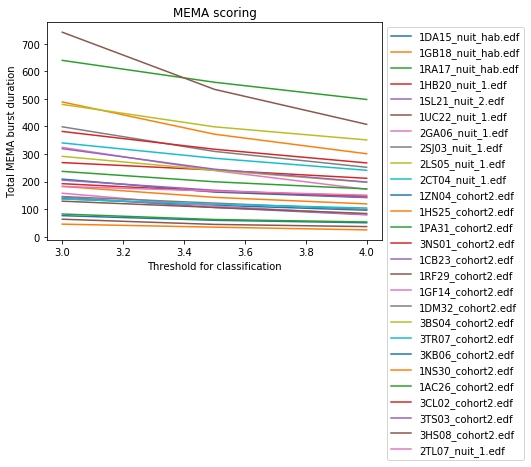

In [7]:
plt.figure()
plt.figure()
value = "Total MEMA burst duration"
plot_inter_subjects(results, value)

## 2.d Comparing episode frequency with variability tinnitus

Nb_patients in each group : 
Tinnitus decrease : 10, ['1DA15', '1HB20', '1SL21', '1ZN04', '3NS01', '3BS04', '3TR07', '3KB06', '3CL02', '3HS08']
Tinnitus increase : 9, ['1GB18', '1RA17', '1UC22', '1HS25', '1GF14', '1DM32', '1NS30', '1AC26', '3TS03']
Tinnitus control : 5, ['2GA06', '2SJ03', '2LS05', '2CT04', '2TL07']
Tinnitus stable : 3, ['1PA31', '1CB23', '1RF29']


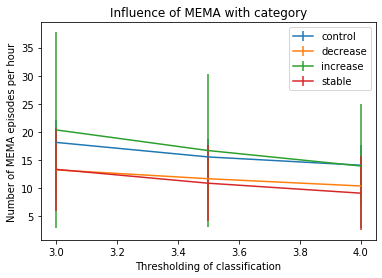

In [8]:
# d.1 GROUP BY TINNITUS VOLUME VARIATION
reports = None
for filename in results.keys():
    report = pd.DataFrame(results[filename]["reports"])
    report["THR_classif"] = THR_classif[:,1]
    report["filename"] = filename
    if reports is None:
        reports = report
    else:
        reports = reports.append(report, ignore_index=True)

        
import math     
def map_category(x):
    if x < (-0.1):
        return "decrease"
    elif x > (0.1):
        return "increase"
    elif math.isnan(x):
        return "control"
    else:
        return "stable"
data_info["category"] = data_info["mask_delta"].apply(map_category)

reports = reports.merge(data_info, on="filename")

# d.2 Preparing values for correlation scatter plots
    
print("Nb_patients in each group : ")
for category in list(data_info['category'].unique()):
    print(f"Tinnitus {category} : {(data_info['category']==category).sum()}, {(list(data_info[data_info['category']==category]['subject']))}")

report_mean = reports.groupby(['category', 'THR_classif']).mean()
report_std =  reports.groupby(['category', 'THR_classif']).std()


# d.3 Displaying
plt.figure()
value = "Number of MEMA episodes per hour"
for category in list(report_mean.index.get_level_values(0).unique()):
    plt.errorbar(THR_classif[:,1],report_mean.loc[category][value], report_std.loc[category][value], label = category)
plt.title("Influence of MEMA with category" )
plt.xlabel('Thresholding of classification')
plt.ylabel(value)
plt.legend()

## 2.e Etiology

etiology (?) : 21, ['1DA15', '1DA15', '1DA15', '1GB18', '1GB18', '1GB18', '1RA17', '1RA17', '1RA17', '1HB20', '1HB20', '1HB20', '1SL21', '1SL21', '1SL21', '1UC22', '1UC22', '1UC22', '1ZN04', '1ZN04', '1ZN04']
etiology (group1) : 24, ['1HS25', '1HS25', '1HS25', '1PA31', '1PA31', '1PA31', '1CB23', '1CB23', '1CB23', '1RF29', '1RF29', '1RF29', '1GF14', '1GF14', '1GF14', '1DM32', '1DM32', '1DM32', '1NS30', '1NS30', '1NS30', '1AC26', '1AC26', '1AC26']
etiology (group3) : 21, ['3NS01', '3NS01', '3NS01', '3BS04', '3BS04', '3BS04', '3TR07', '3TR07', '3TR07', '3KB06', '3KB06', '3KB06', '3CL02', '3CL02', '3CL02', '3TS03', '3TS03', '3TS03', '3HS08', '3HS08', '3HS08']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

?_4.0 v.s. group1_4.0: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.683e-02 U_stat=4.700e+01
group1_4.0 v.s. group3_4.0: Mann-Whitney-Wilcoxon t

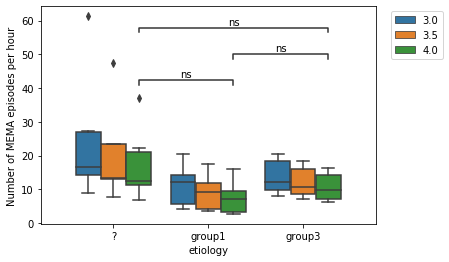

obstructed_ear (False) : 33, ['1DA15', '1DA15', '1DA15', '1RA17', '1RA17', '1RA17', '1HB20', '1HB20', '1HB20', '1HS25', '1HS25', '1HS25', '1CB23', '1CB23', '1CB23', '1RF29', '1RF29', '1RF29', '3TR07', '3TR07', '3TR07', '3KB06', '3KB06', '3KB06', '3CL02', '3CL02', '3CL02', '3TS03', '3TS03', '3TS03', '3HS08', '3HS08', '3HS08']
obstructed_ear (True) : 33, ['1GB18', '1GB18', '1GB18', '1SL21', '1SL21', '1SL21', '1UC22', '1UC22', '1UC22', '1ZN04', '1ZN04', '1ZN04', '1PA31', '1PA31', '1PA31', '3NS01', '3NS01', '3NS01', '1GF14', '1GF14', '1GF14', '1DM32', '1DM32', '1DM32', '3BS04', '3BS04', '3BS04', '1NS30', '1NS30', '1NS30', '1AC26', '1AC26', '1AC26']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_4.0 v.s. True_4.0: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.307e-01 U_stat=4.800e+01


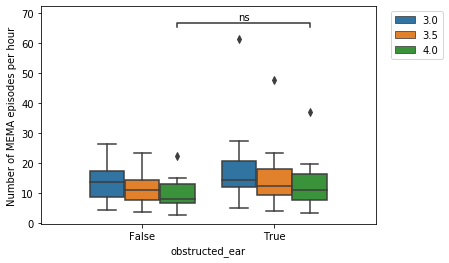

otalgy (False) : 54, ['1DA15', '1DA15', '1DA15', '1GB18', '1GB18', '1GB18', '1RA17', '1RA17', '1RA17', '1HB20', '1HB20', '1HB20', '1SL21', '1SL21', '1SL21', '1UC22', '1UC22', '1UC22', '1ZN04', '1ZN04', '1ZN04', '1HS25', '1HS25', '1HS25', '3NS01', '3NS01', '3NS01', '1CB23', '1CB23', '1CB23', '1RF29', '1RF29', '1RF29', '1GF14', '1GF14', '1GF14', '3BS04', '3BS04', '3BS04', '3TR07', '3TR07', '3TR07', '3KB06', '3KB06', '3KB06', '1NS30', '1NS30', '1NS30', '3CL02', '3CL02', '3CL02', '3TS03', '3TS03', '3TS03']
otalgy (True) : 12, ['1PA31', '1PA31', '1PA31', '1DM32', '1DM32', '1DM32', '1AC26', '1AC26', '1AC26', '3HS08', '3HS08', '3HS08']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_4.0 v.s. True_4.0: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.187e-01 U_stat=4.600e+01


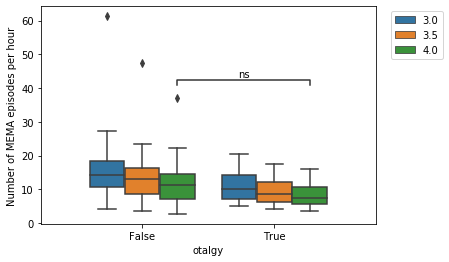

hyperacusis (True) : 33, ['1DA15', '1DA15', '1DA15', '1ZN04', '1ZN04', '1ZN04', '1PA31', '1PA31', '1PA31', '1CB23', '1CB23', '1CB23', '1RF29', '1RF29', '1RF29', '1GF14', '1GF14', '1GF14', '1DM32', '1DM32', '1DM32', '3KB06', '3KB06', '3KB06', '3CL02', '3CL02', '3CL02', '3TS03', '3TS03', '3TS03', '3HS08', '3HS08', '3HS08']
hyperacusis (False) : 33, ['1GB18', '1GB18', '1GB18', '1RA17', '1RA17', '1RA17', '1HB20', '1HB20', '1HB20', '1SL21', '1SL21', '1SL21', '1UC22', '1UC22', '1UC22', '1HS25', '1HS25', '1HS25', '3NS01', '3NS01', '3NS01', '3BS04', '3BS04', '3BS04', '3TR07', '3TR07', '3TR07', '1NS30', '1NS30', '1NS30', '1AC26', '1AC26', '1AC26']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_4.0 v.s. True_4.0: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.372e-01 U_stat=7.900e+01


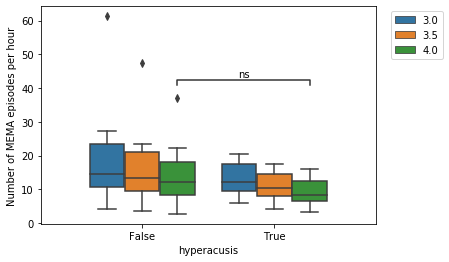

jaw_popping (True) : 39, ['1DA15', '1DA15', '1DA15', '1RA17', '1RA17', '1RA17', '1SL21', '1SL21', '1SL21', '1ZN04', '1ZN04', '1ZN04', '1HS25', '1HS25', '1HS25', '1PA31', '1PA31', '1PA31', '3NS01', '3NS01', '3NS01', '1CB23', '1CB23', '1CB23', '1GF14', '1GF14', '1GF14', '1DM32', '1DM32', '1DM32', '3BS04', '3BS04', '3BS04', '1NS30', '1NS30', '1NS30', '3HS08', '3HS08', '3HS08']
jaw_popping (False) : 27, ['1GB18', '1GB18', '1GB18', '1HB20', '1HB20', '1HB20', '1UC22', '1UC22', '1UC22', '1RF29', '1RF29', '1RF29', '3TR07', '3TR07', '3TR07', '3KB06', '3KB06', '3KB06', '1AC26', '1AC26', '1AC26', '3CL02', '3CL02', '3CL02', '3TS03', '3TS03', '3TS03']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_4.0 v.s. True_4.0: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.887e-01 U_stat=6.500e+01


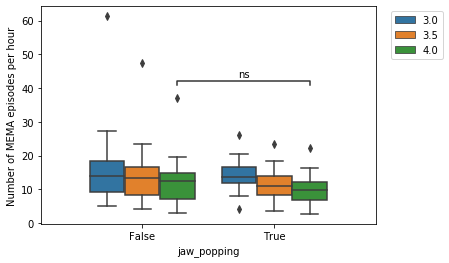

jaw_pain_and_fatigue (False) : 51, ['1DA15', '1DA15', '1DA15', '1GB18', '1GB18', '1GB18', '1RA17', '1RA17', '1RA17', '1HB20', '1HB20', '1HB20', '1SL21', '1SL21', '1SL21', '1UC22', '1UC22', '1UC22', '1ZN04', '1ZN04', '1ZN04', '3NS01', '3NS01', '3NS01', '1CB23', '1CB23', '1CB23', '1RF29', '1RF29', '1RF29', '1GF14', '1GF14', '1GF14', '3TR07', '3TR07', '3TR07', '3KB06', '3KB06', '3KB06', '1NS30', '1NS30', '1NS30', '3CL02', '3CL02', '3CL02', '3TS03', '3TS03', '3TS03', '3HS08', '3HS08', '3HS08']
jaw_pain_and_fatigue (True) : 15, ['1HS25', '1HS25', '1HS25', '1PA31', '1PA31', '1PA31', '1DM32', '1DM32', '1DM32', '3BS04', '3BS04', '3BS04', '1AC26', '1AC26', '1AC26']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_4.0 v.s. True_4.0: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.383e-01 U_stat=4.900e+01


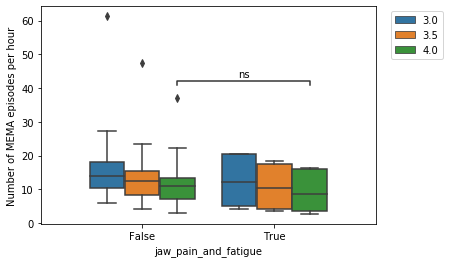

somatosensory_modulation (False) : 39, ['1DA15', '1DA15', '1DA15', '1GB18', '1GB18', '1GB18', '1HB20', '1HB20', '1HB20', '1SL21', '1SL21', '1SL21', '1UC22', '1UC22', '1UC22', '1ZN04', '1ZN04', '1ZN04', '3NS01', '3NS01', '3NS01', '1RF29', '1RF29', '1RF29', '1DM32', '1DM32', '1DM32', '3KB06', '3KB06', '3KB06', '1NS30', '1NS30', '1NS30', '3TS03', '3TS03', '3TS03', '3HS08', '3HS08', '3HS08']
somatosensory_modulation (True) : 27, ['1RA17', '1RA17', '1RA17', '1HS25', '1HS25', '1HS25', '1PA31', '1PA31', '1PA31', '1CB23', '1CB23', '1CB23', '1GF14', '1GF14', '1GF14', '3BS04', '3BS04', '3BS04', '3TR07', '3TR07', '3TR07', '1AC26', '1AC26', '1AC26', '3CL02', '3CL02', '3CL02']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_4.0 v.s. True_4.0: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.894e-01 U_stat=6.300e+01


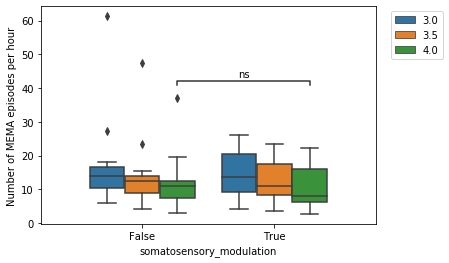

nap_modulation (False) : 48, ['1DA15', '1DA15', '1DA15', '1GB18', '1GB18', '1GB18', '1RA17', '1RA17', '1RA17', '1ZN04', '1ZN04', '1ZN04', '1PA31', '1PA31', '1PA31', '3NS01', '3NS01', '3NS01', '1GF14', '1GF14', '1GF14', '1DM32', '1DM32', '1DM32', '3BS04', '3BS04', '3BS04', '3TR07', '3TR07', '3TR07', '3KB06', '3KB06', '3KB06', '1NS30', '1NS30', '1NS30', '1AC26', '1AC26', '1AC26', '3CL02', '3CL02', '3CL02', '3TS03', '3TS03', '3TS03', '3HS08', '3HS08', '3HS08']
nap_modulation (True) : 18, ['1HB20', '1HB20', '1HB20', '1SL21', '1SL21', '1SL21', '1UC22', '1UC22', '1UC22', '1HS25', '1HS25', '1HS25', '1CB23', '1CB23', '1CB23', '1RF29', '1RF29', '1RF29']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_4.0 v.s. True_4.0: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.803e-01 U_stat=5.600e+01


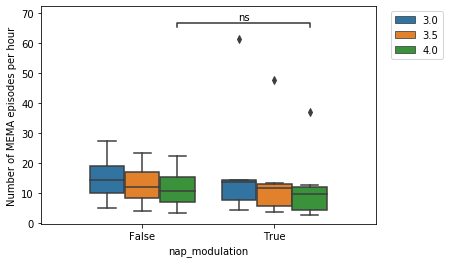

snoring (False) : 45, ['1DA15', '1DA15', '1DA15', '1GB18', '1GB18', '1GB18', '1RA17', '1RA17', '1RA17', '1ZN04', '1ZN04', '1ZN04', '1HS25', '1HS25', '1HS25', '3NS01', '3NS01', '3NS01', '1CB23', '1CB23', '1CB23', '1GF14', '1GF14', '1GF14', '1DM32', '1DM32', '1DM32', '3BS04', '3BS04', '3BS04', '3TR07', '3TR07', '3TR07', '1NS30', '1NS30', '1NS30', '3CL02', '3CL02', '3CL02', '3TS03', '3TS03', '3TS03', '3HS08', '3HS08', '3HS08']
snoring (True) : 21, ['1HB20', '1HB20', '1HB20', '1SL21', '1SL21', '1SL21', '1UC22', '1UC22', '1UC22', '1PA31', '1PA31', '1PA31', '1RF29', '1RF29', '1RF29', '3KB06', '3KB06', '3KB06', '1AC26', '1AC26', '1AC26']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_4.0 v.s. True_4.0: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=5.300e+01


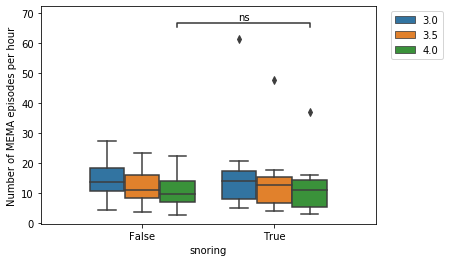

In [9]:
# e.1 GROUP BY ETIOLOGIES
plt.close("all")
from tinnsleep.visualization import etiology_report_with_plot

data = reports.query("category != 'control'")
variable = "Number of MEMA episodes per hour"

hue = "THR_classif"
threshold = 4

etiologies = ['etiology', 'obstructed_ear', 'otalgy', 'hyperacusis', 'jaw_popping', 'jaw_pain_and_fatigue', 
            'somatosensory_modulation', 'nap_modulation', 'snoring']

for etiology in etiologies:
    etiology_report_with_plot(data, etiology, variable, hue=hue, hue_value_for_stats=threshold)
    plt.show()
    

## 2.f Screen for correlated variables

In [10]:
quantitative_variables = list(results[list(results.keys())[0]]["reports"][0].keys())[0:-9] #(remove power ratio a sleep analysis)
print(f'variables: {quantitative_variables}')
effect_variable = ["mask_delta", "mask_per", "VAS_I_delta", "VAS_I_per", "VAS_L_delta", "VAS_L_per"]
#reports["Power Ratio"] = reports["Power Ratio"].apply(sum)

variables: ['Clean MEMA duration', 'Total MEMA burst duration', 'Total number of MEMA burst', 'Number of MEMA bursts per hour', 'MEMA episode NREM count', 'MEMA episode NREM ratio', 'Total number of MEMA episodes', 'Number of MEMA bursts per episode']


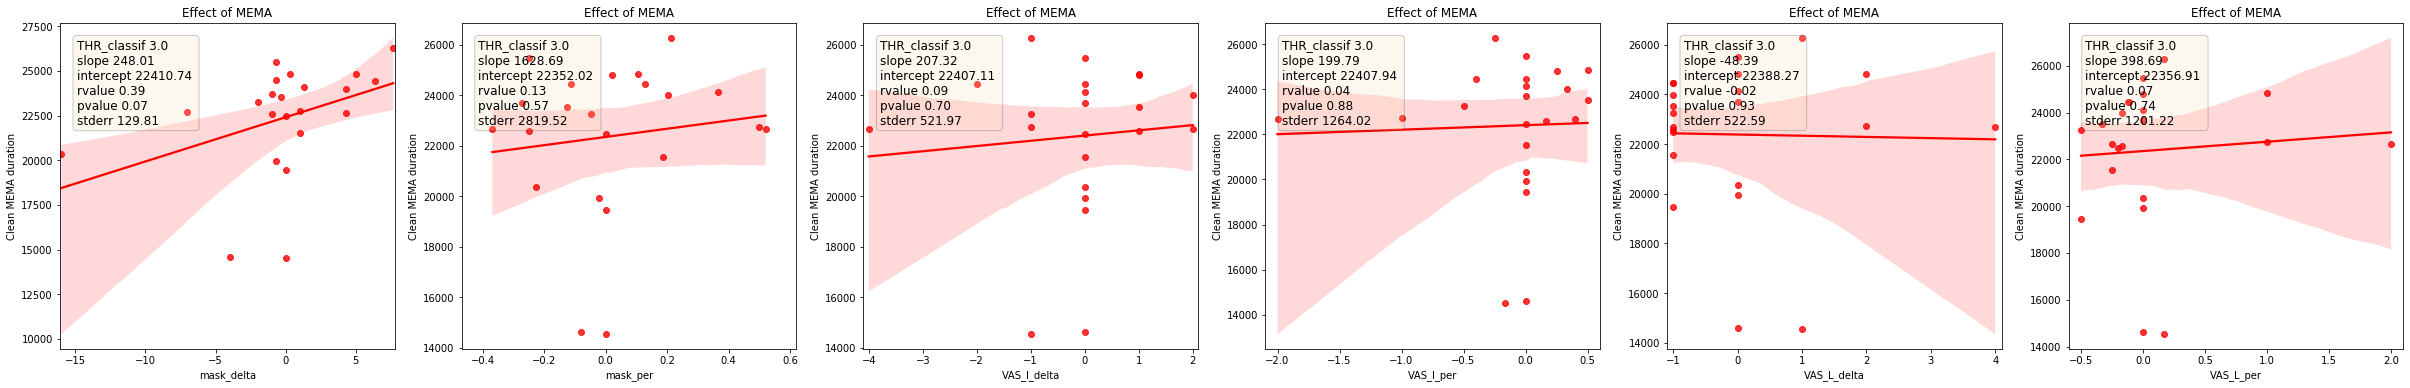

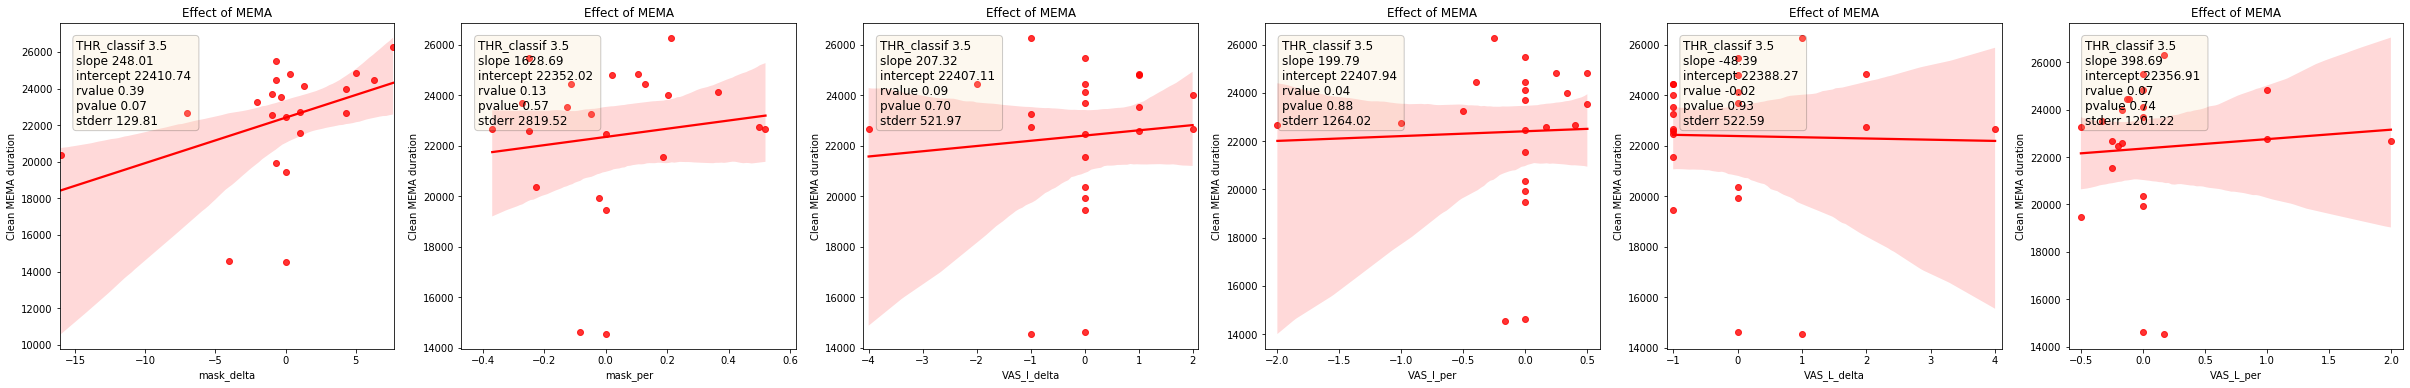

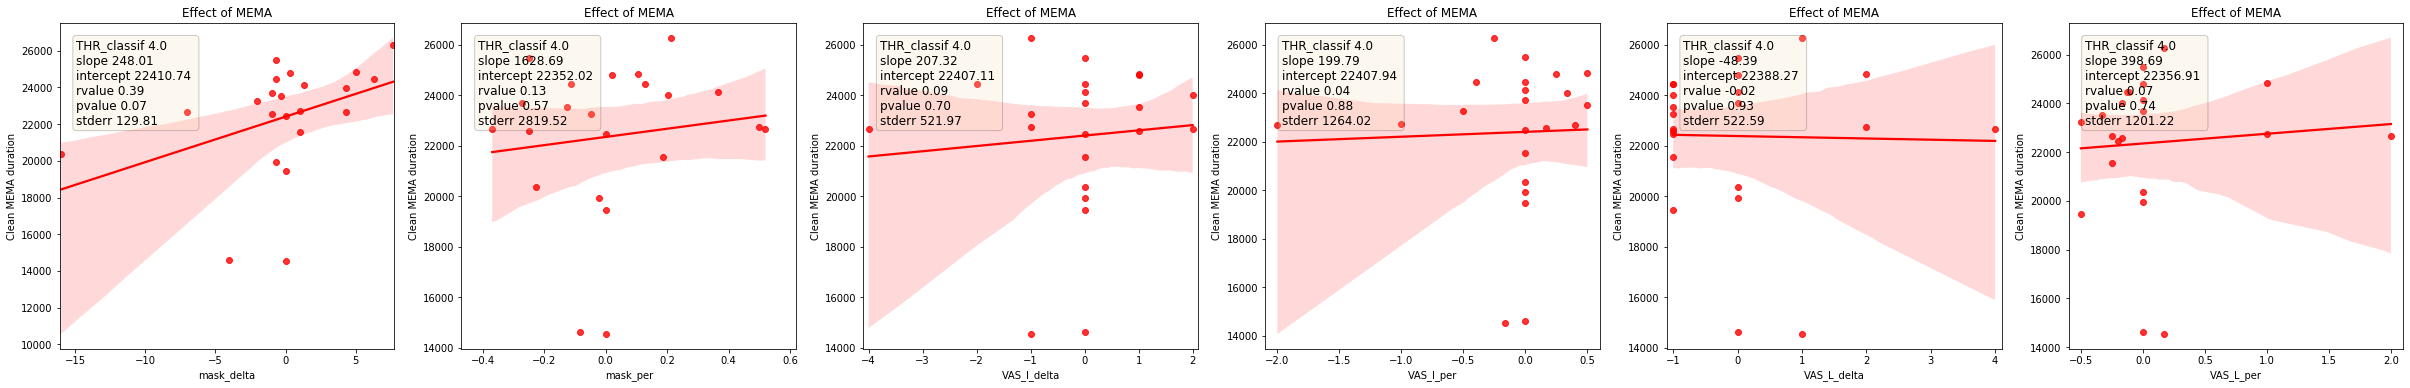

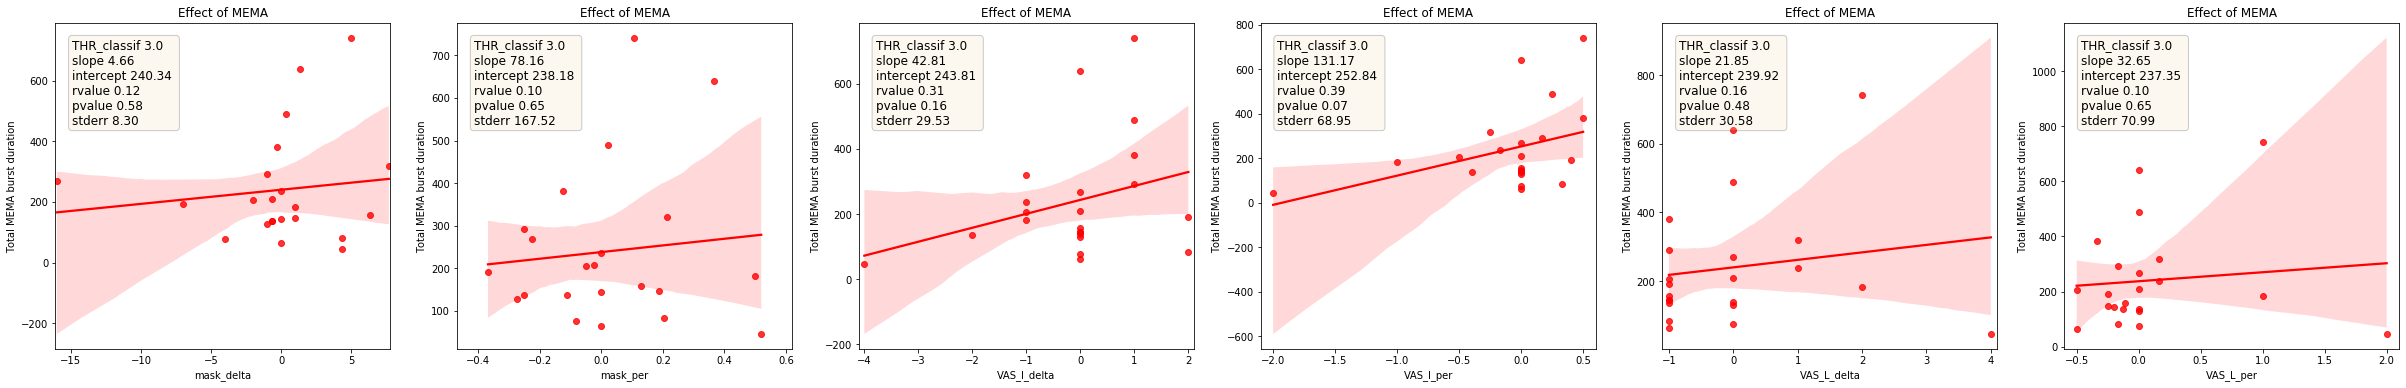

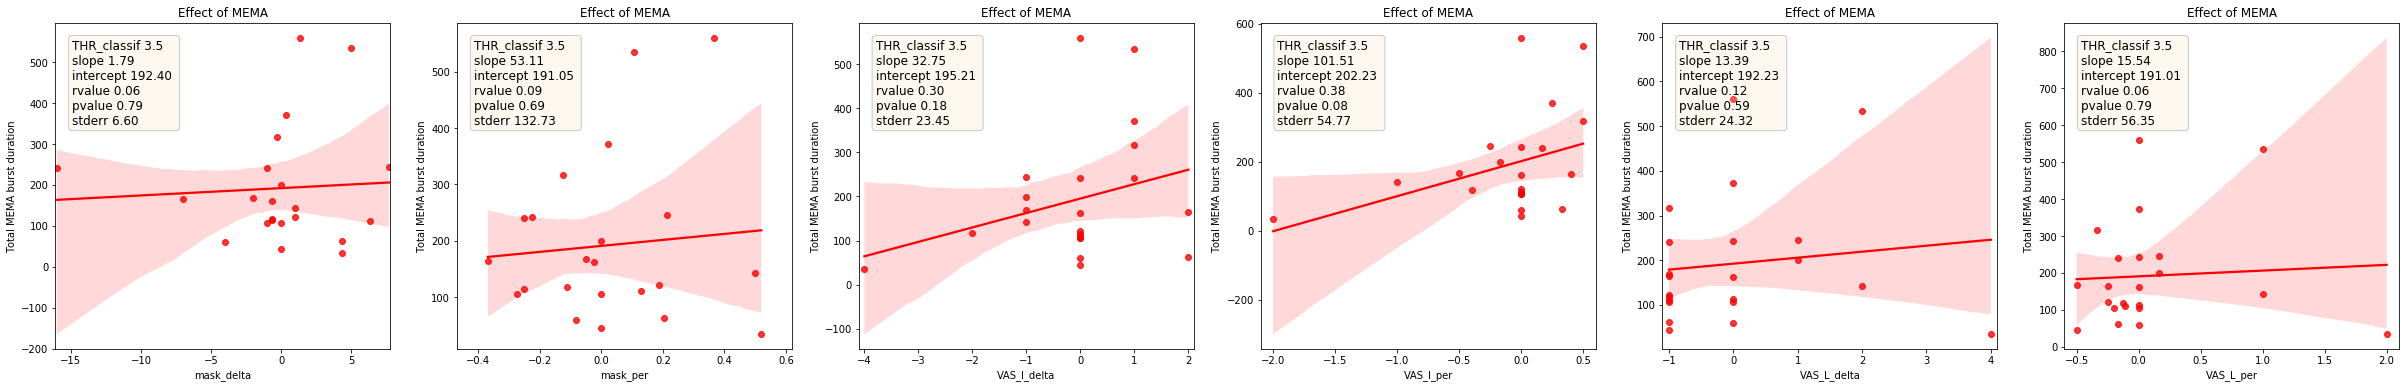

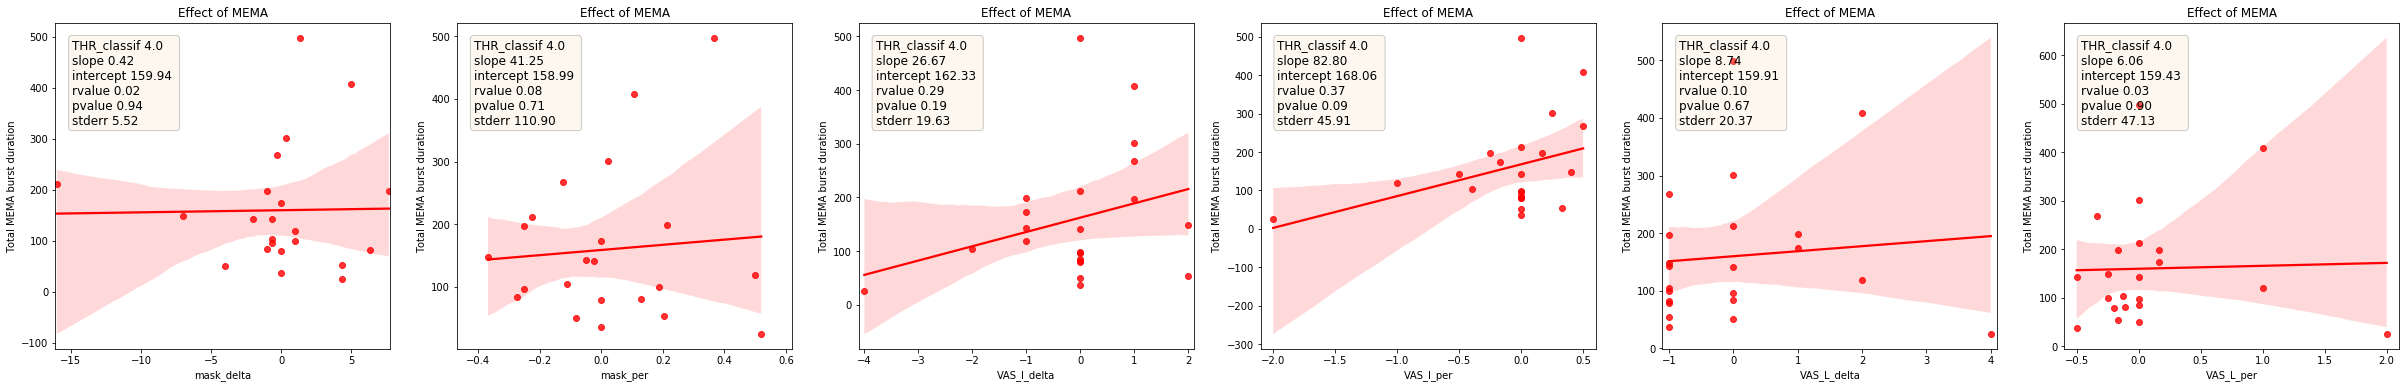

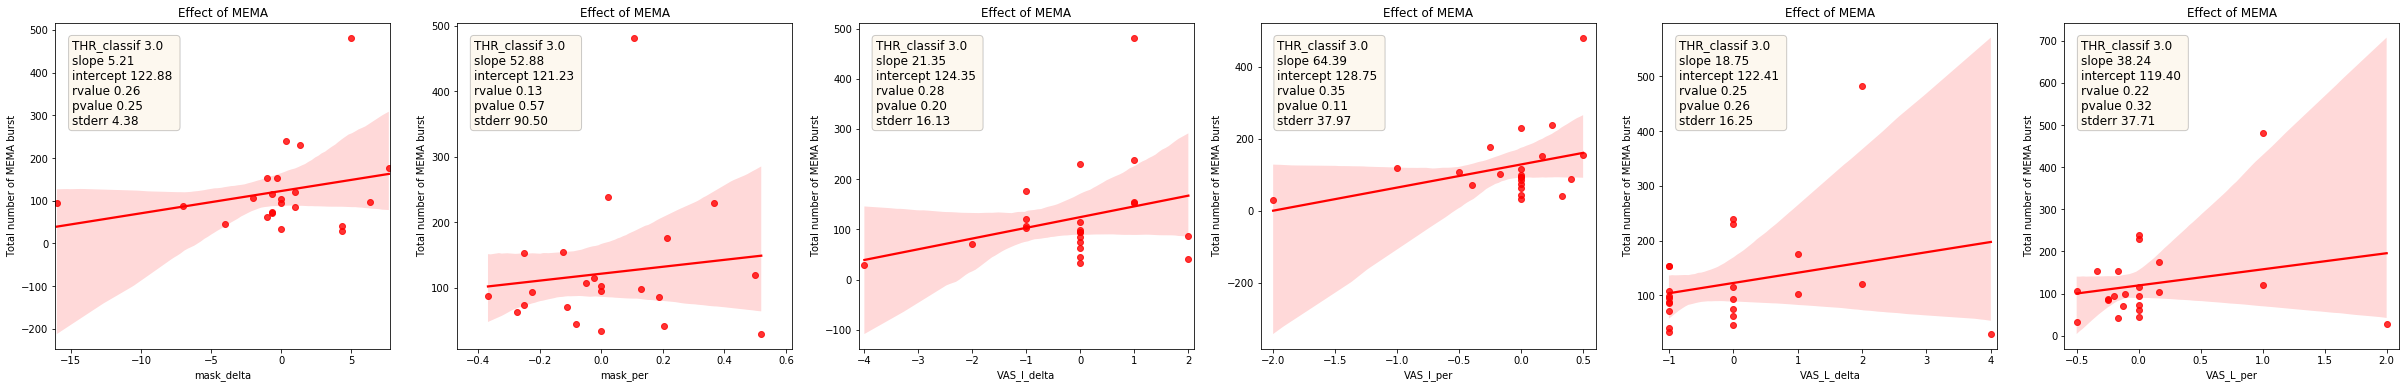

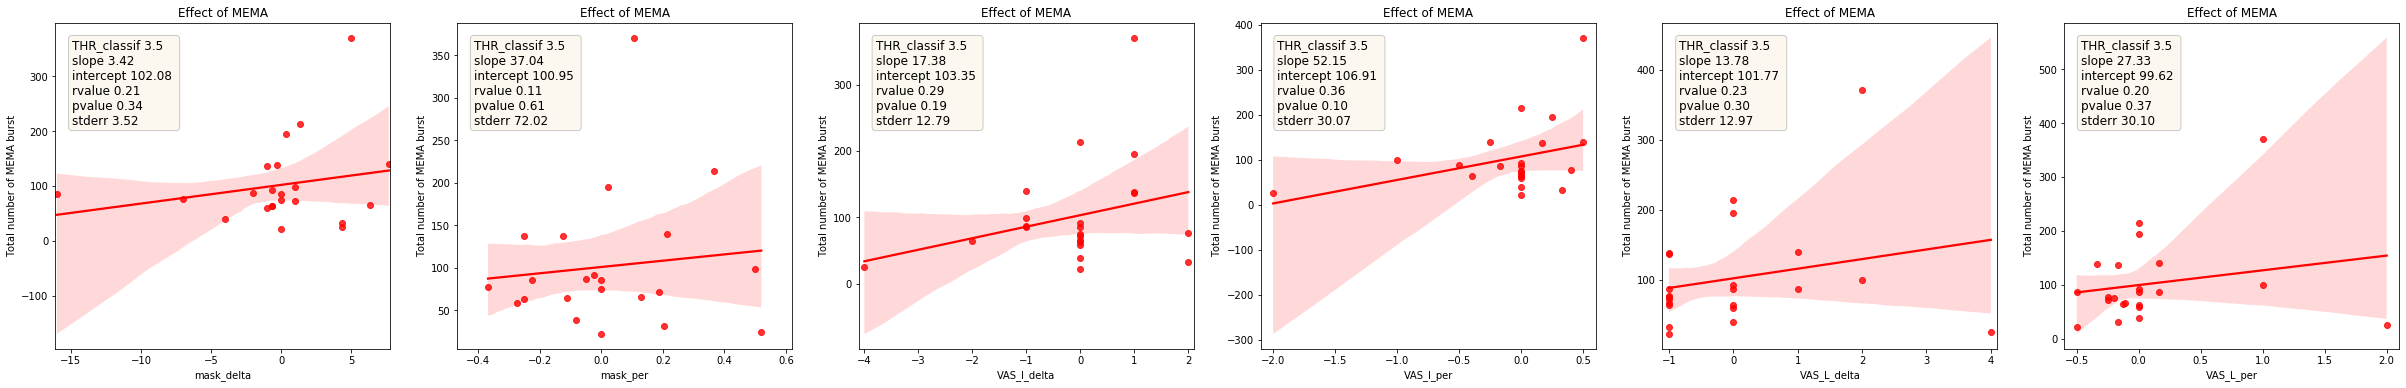

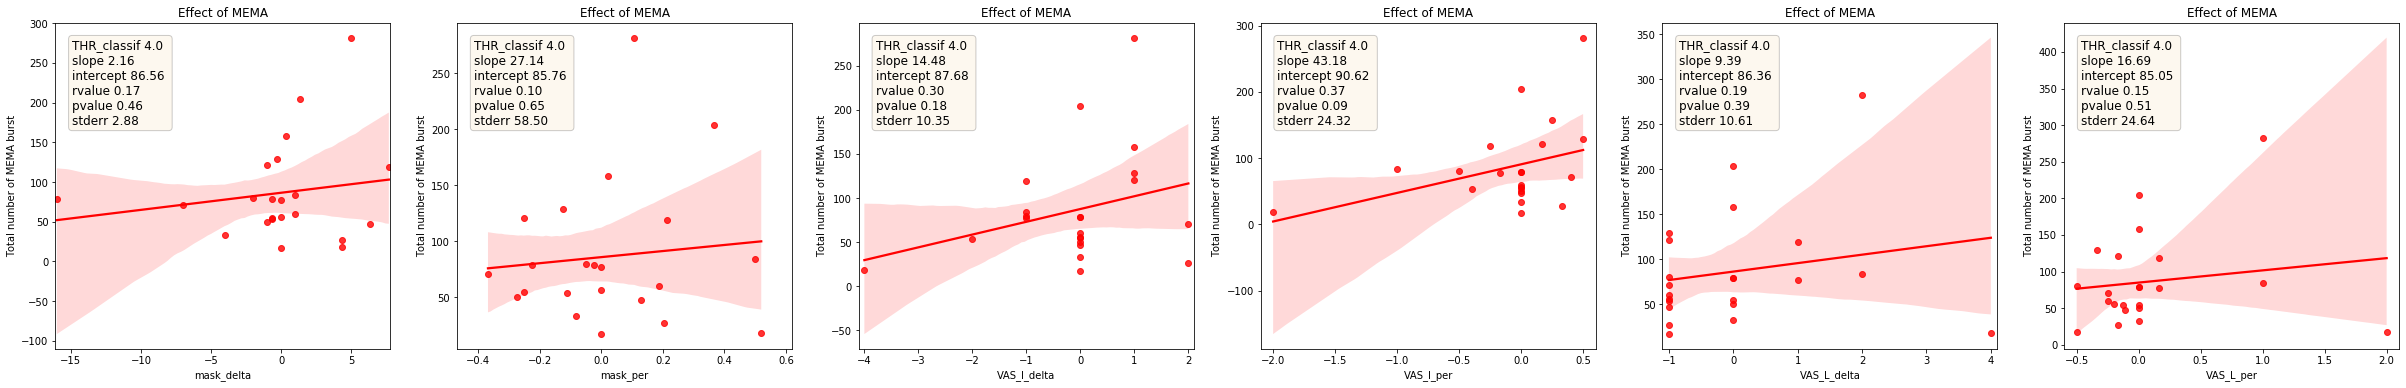

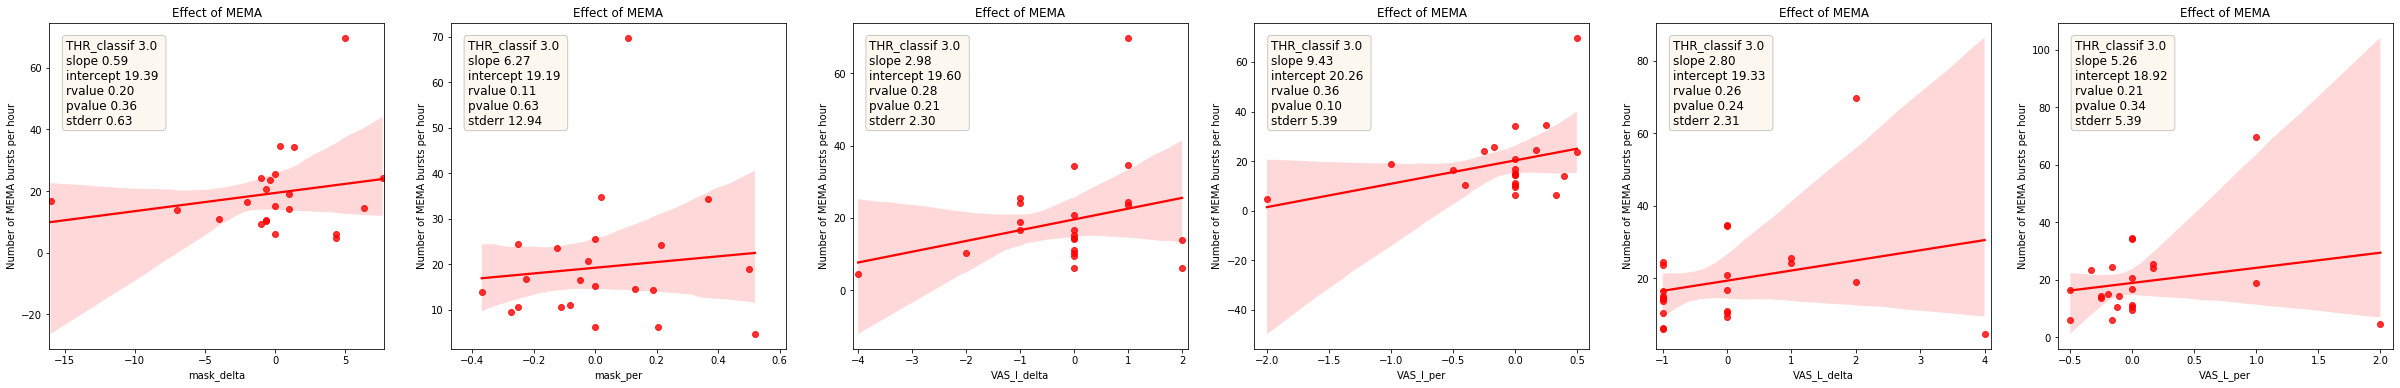

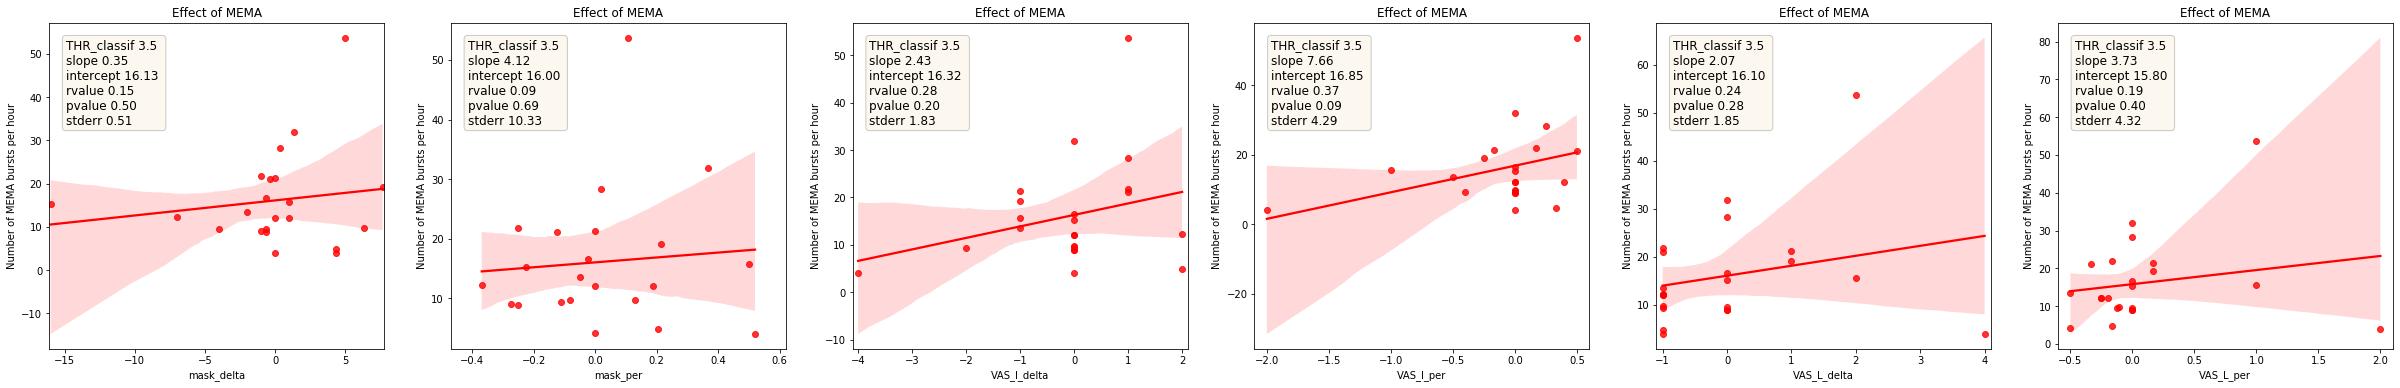

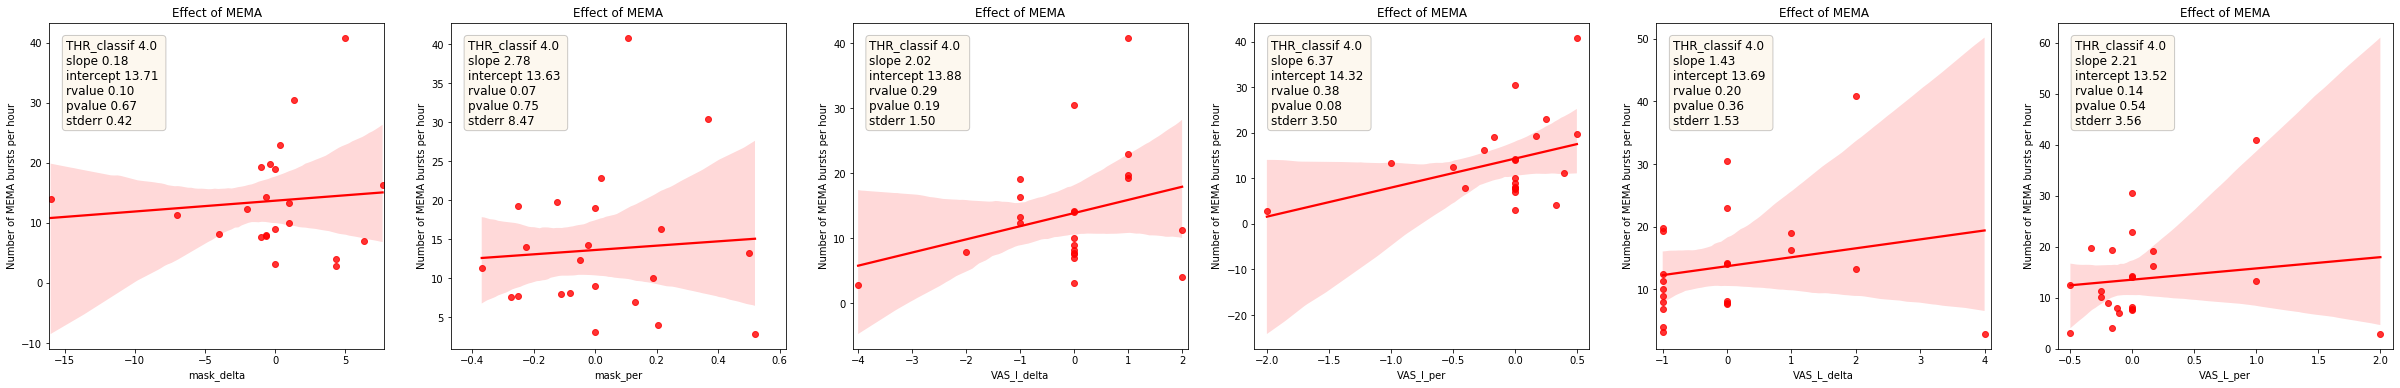

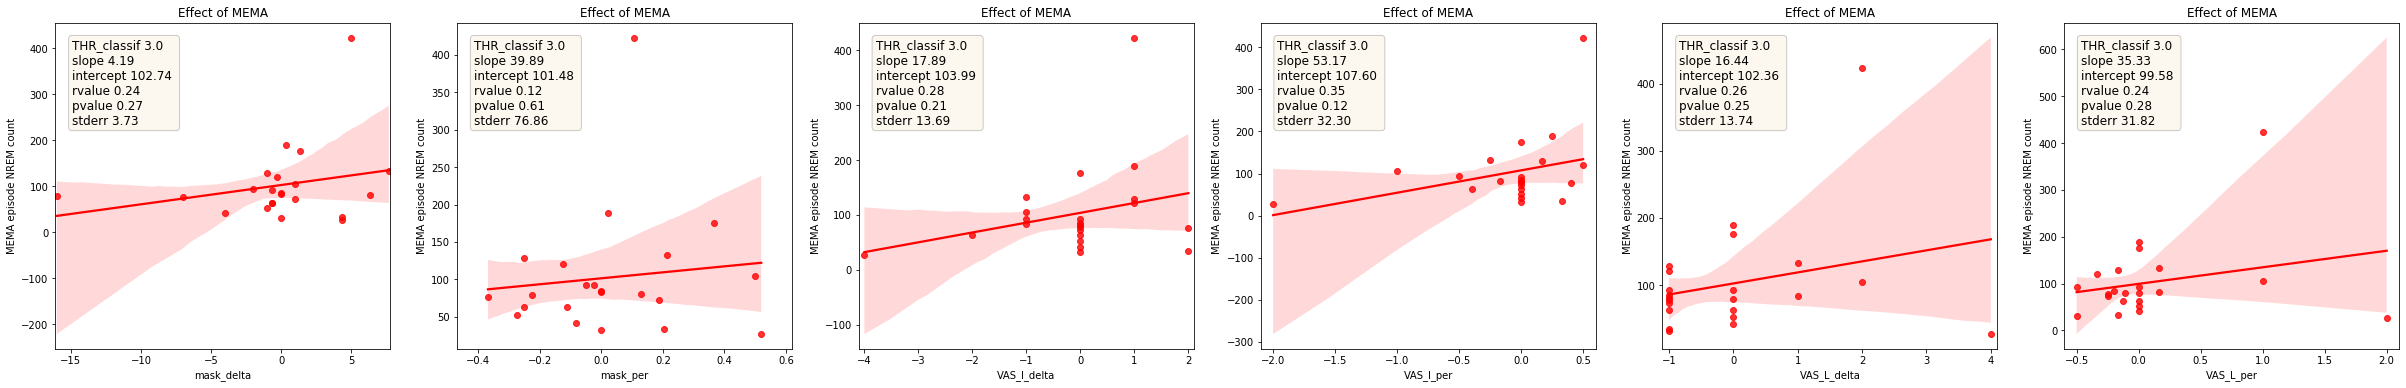

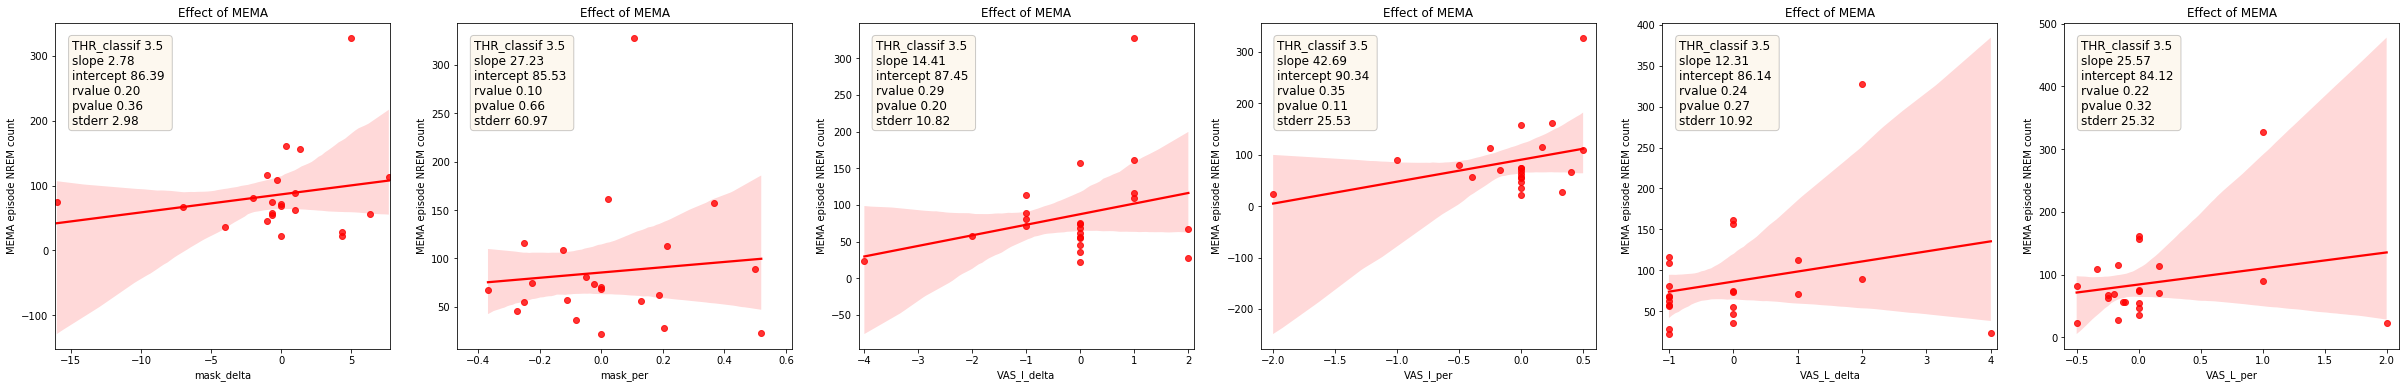

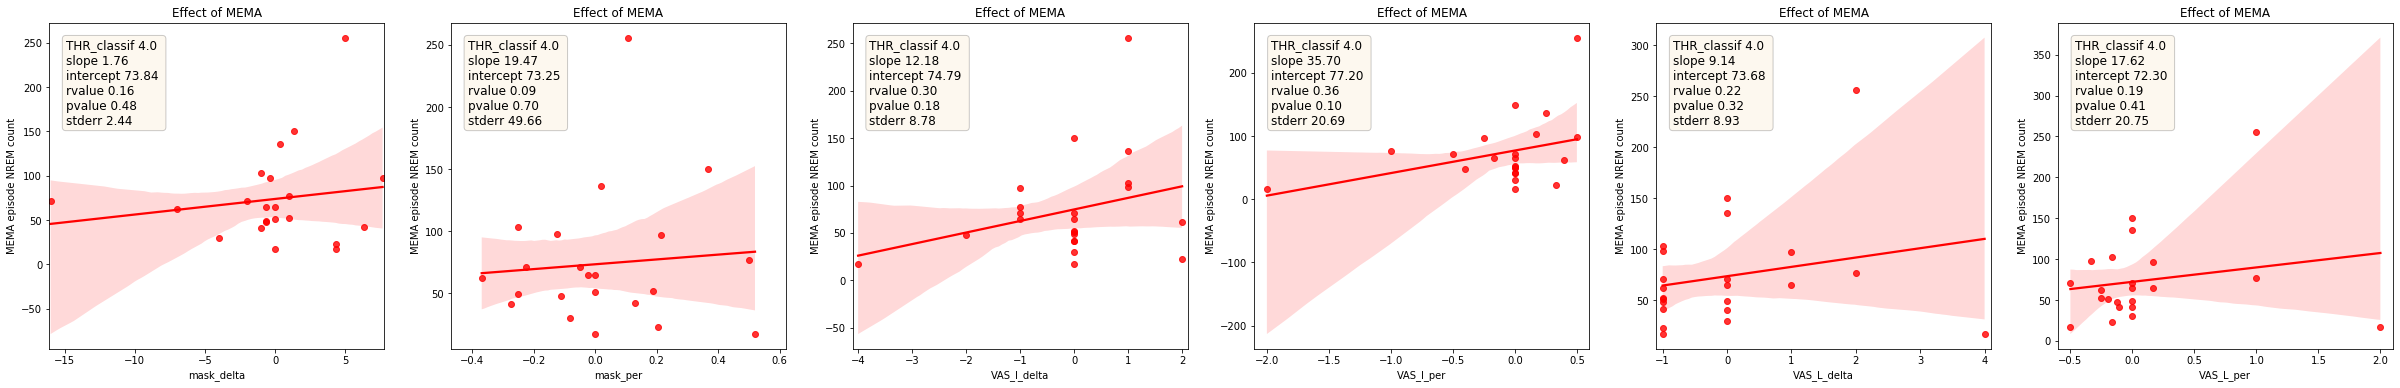

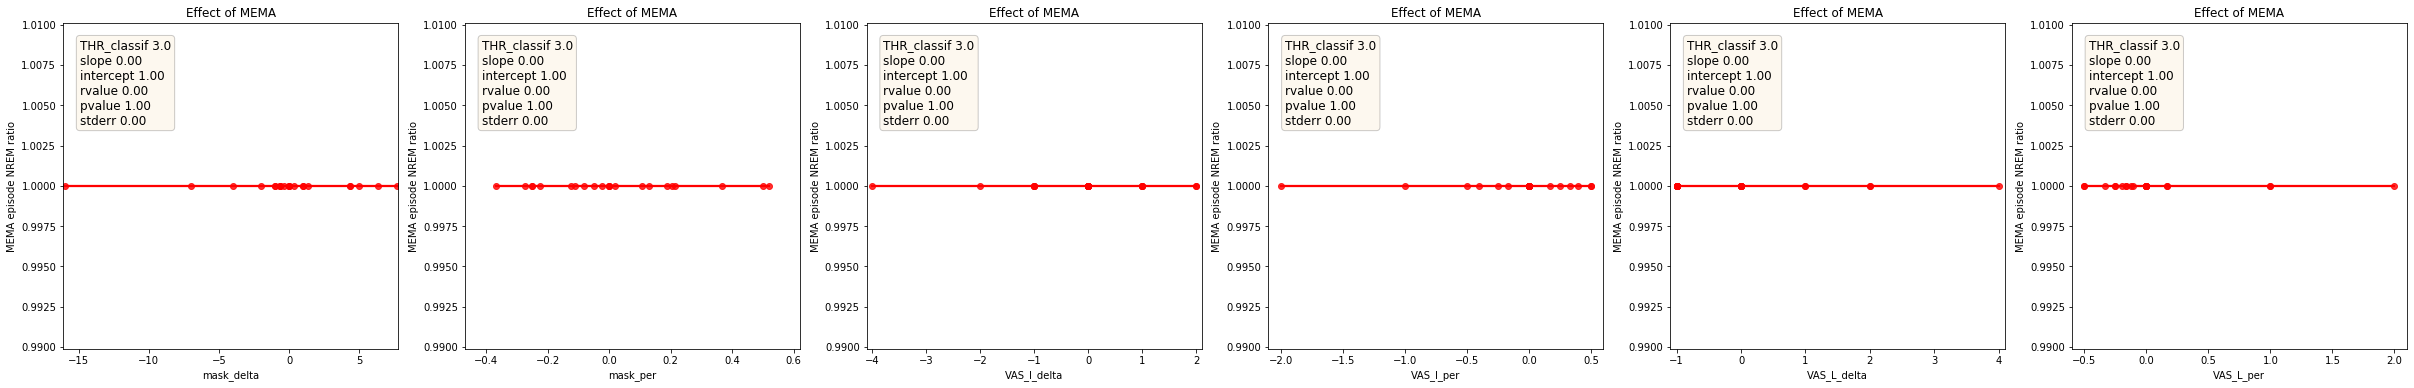

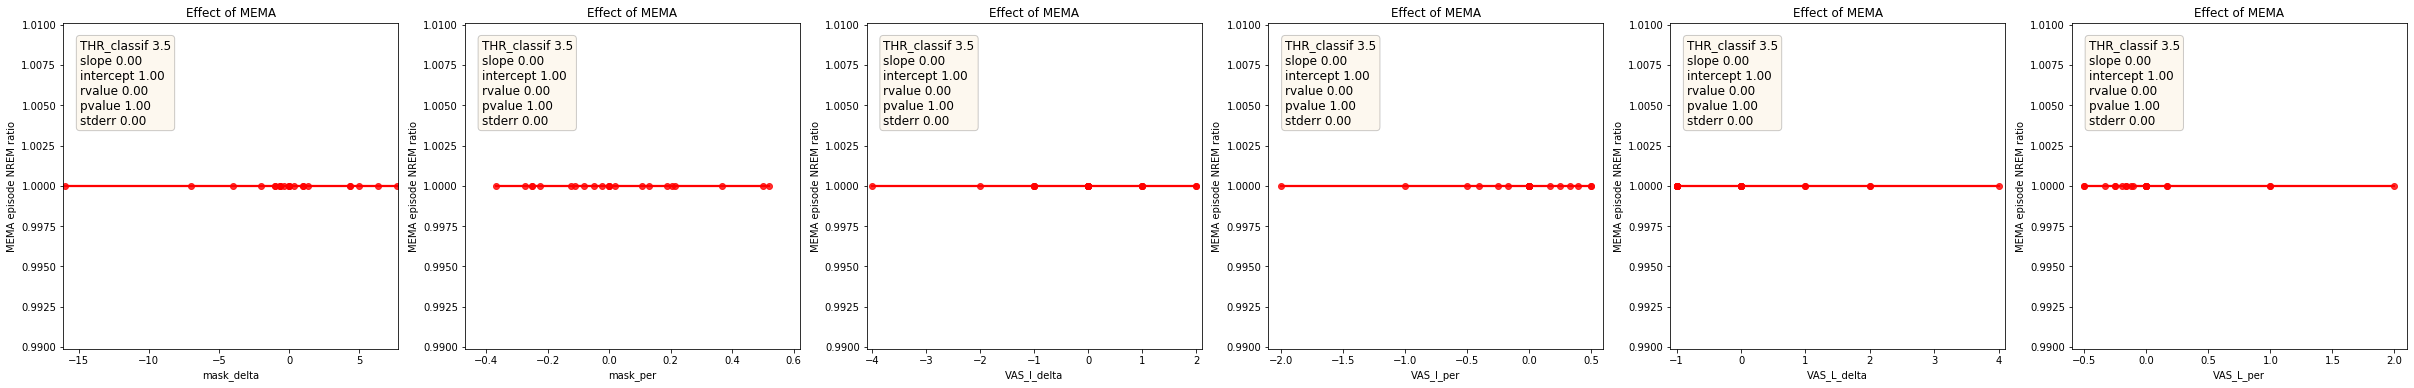

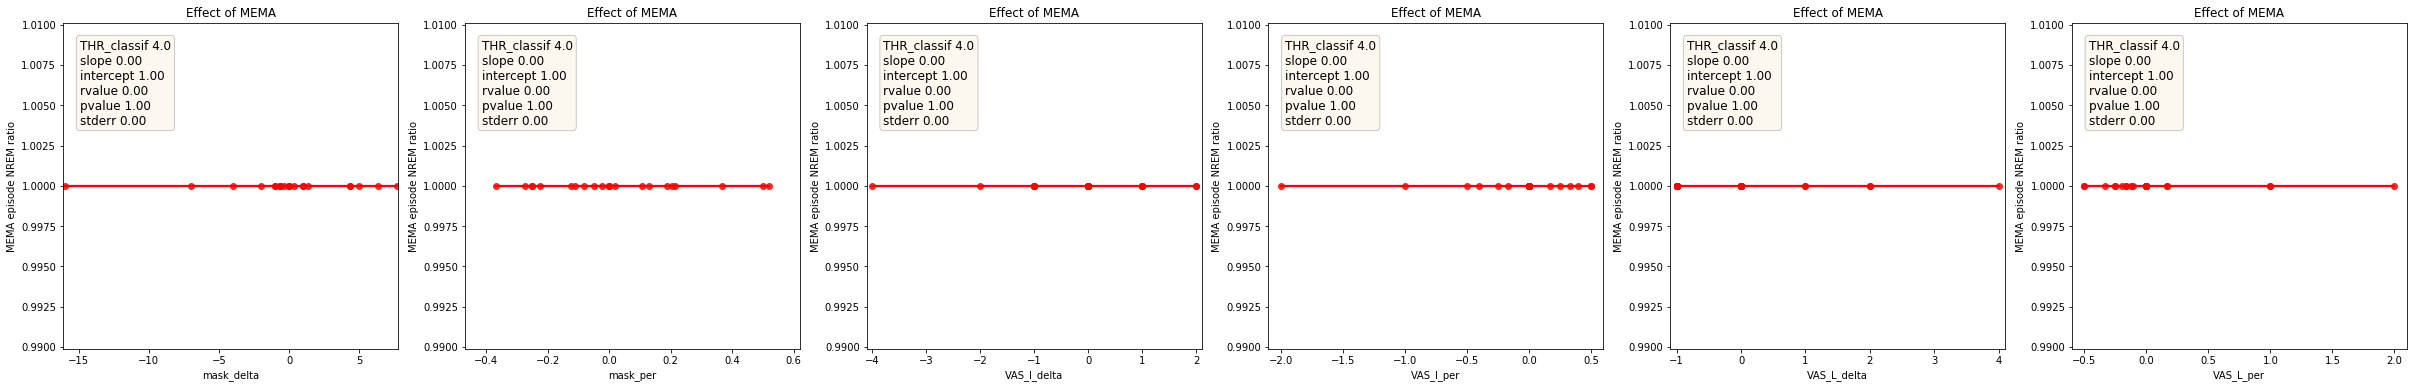

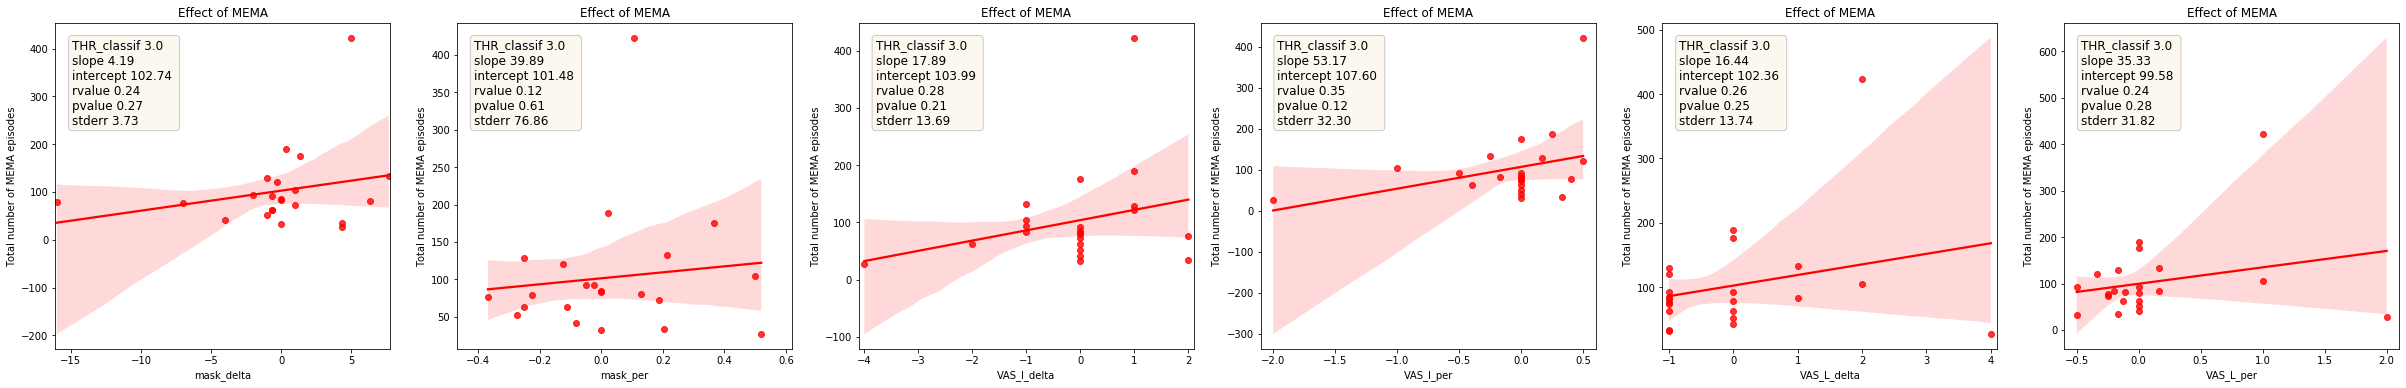

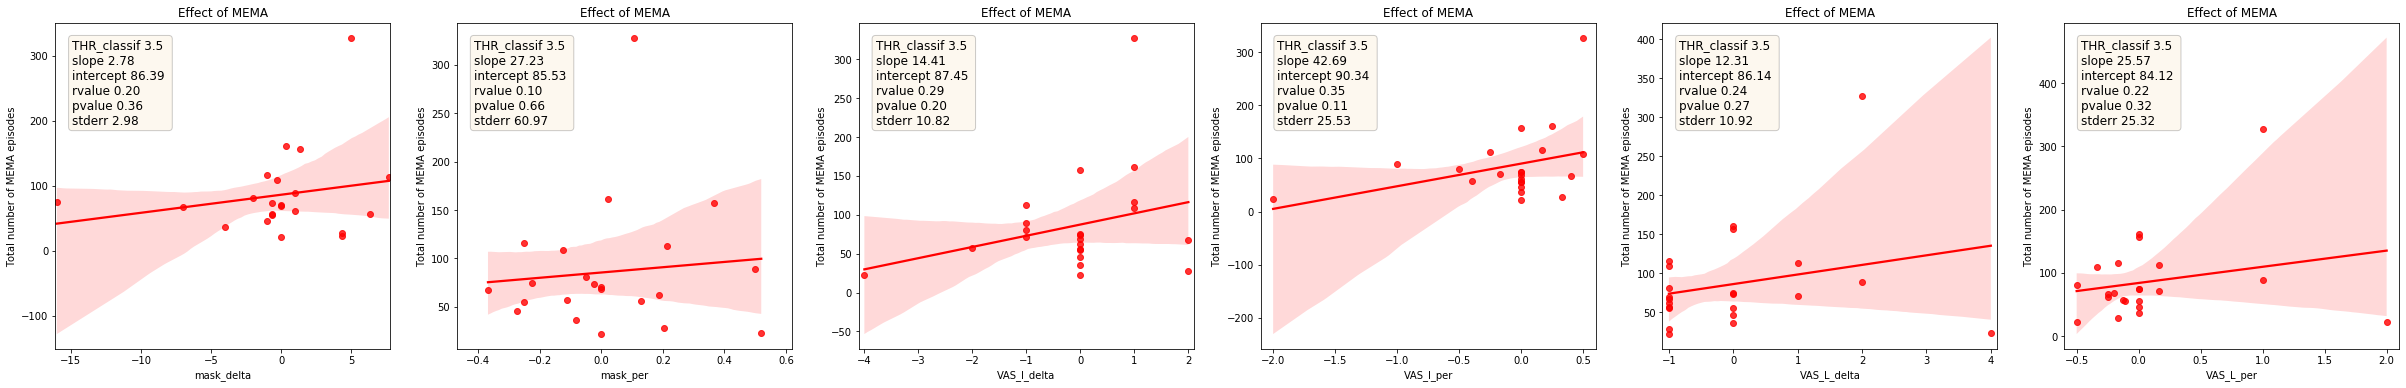

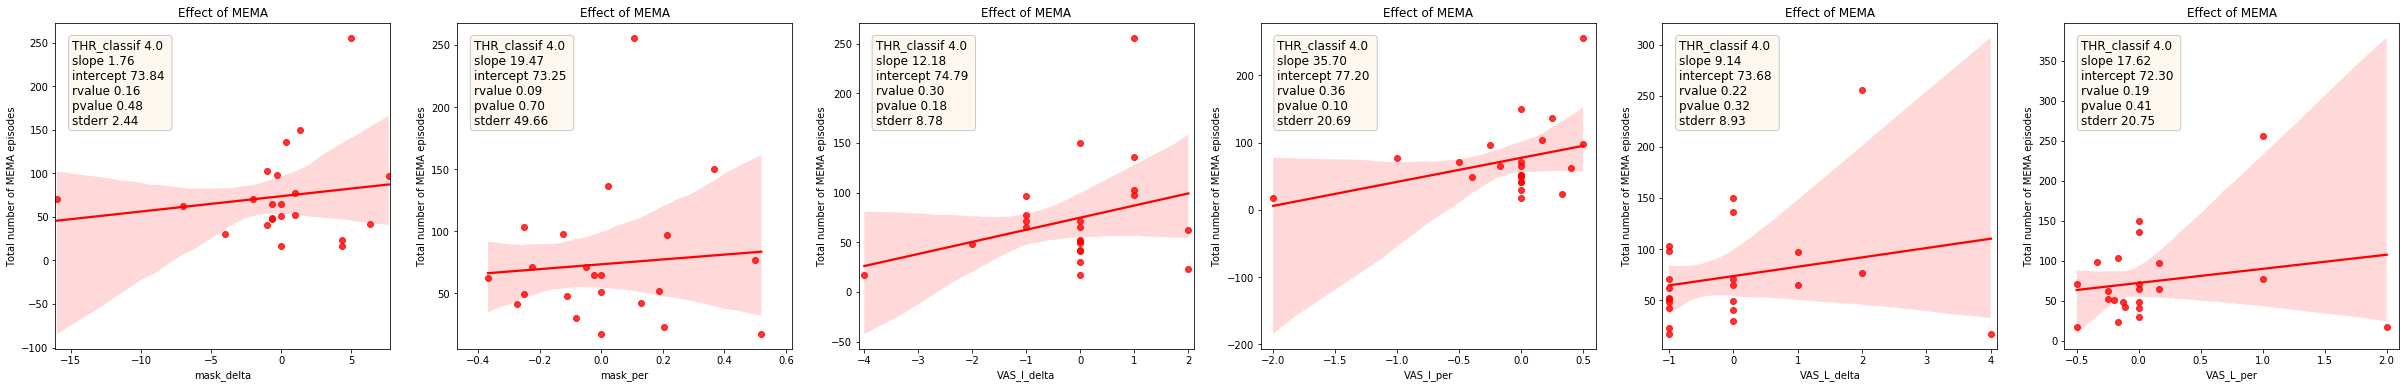

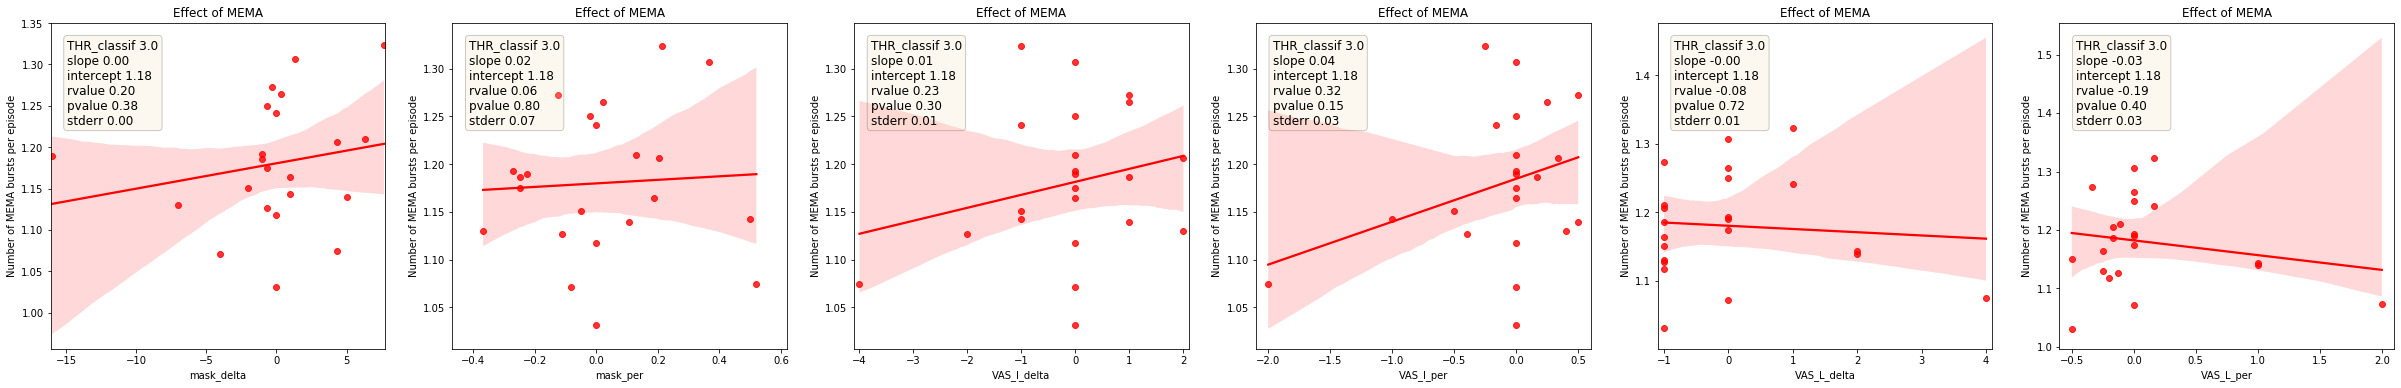

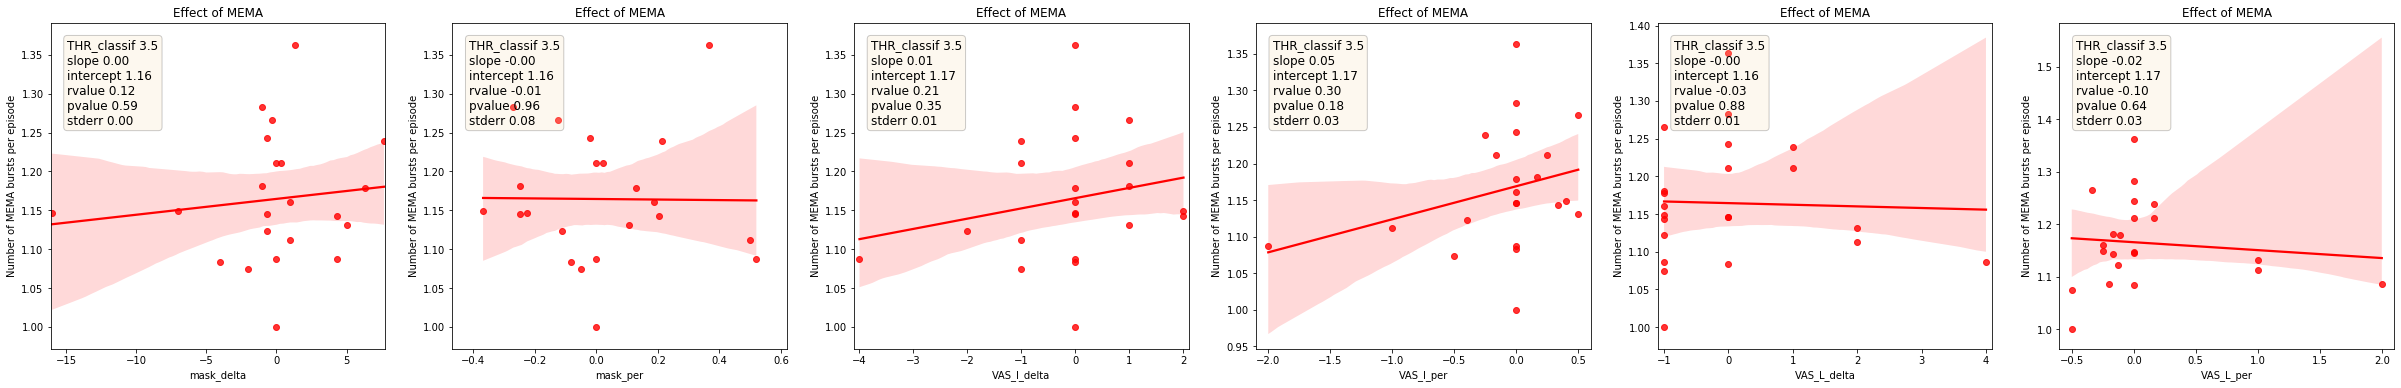

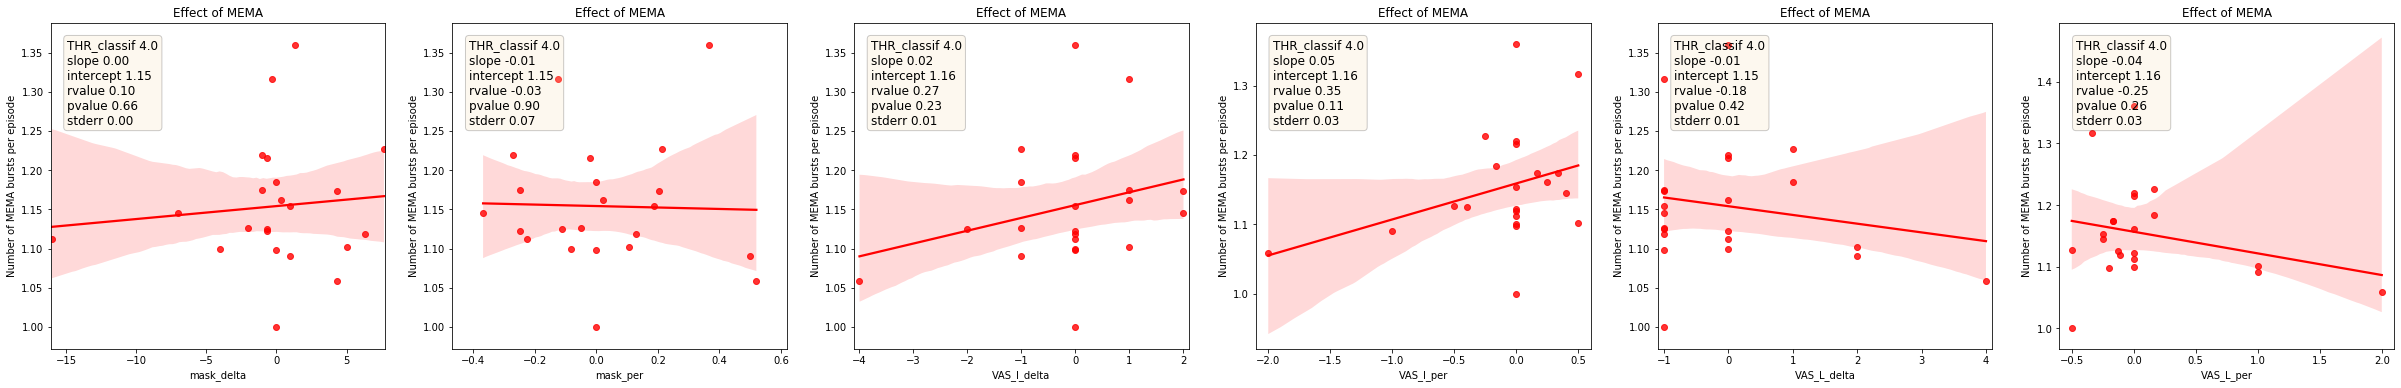

In [11]:
meta_results = pd.DataFrame()
import seaborn as sns
from tinnsleep.visualization import regression_report_with_plot
plt.close("all")

data = reports.query("category != 'control'")
meta_results = regression_report_with_plot(data, effect_variable, quantitative_variables, conditions='THR_classif', title="Effect of MEMA")

In [12]:
meta_results.query("pvalue < 0.05")

,x_axis,y_axis,THR_classif,slope,intercept,rvalue,pvalue,stderr
